In [ ]:
!pip3 install PyBullet

# Lab

The goal of this lab is to populate the pybullet server with real-time information from the Webots world and check whether there is a collision with projected motions of the robot in order to determine suitable grasps. 

You are provided with an URDF files of the crate and  the Robotiq gripper. You can use the gripper coordinate system to locate the crate and then perform relative motions with the gripper. You are also provided with a perfect object detection pipeline that segments all objects in the crate. 

Steps:

- Gain an understanding of how to load URDF and basic geometric objects into the PyBullet physics environment

- Understand the two ways that you can compute collisions: computing the closest points between two objects (does not require simulation step) and computing the actual contact points.

- Compute an Open3D point cloud, down sample it and approximate it with cubic or cyldrical objects. Also populate the box URDF into the same coordinate system. 

- Pick a single can, obtain its bounding object, and compute the position and orientation for grasping it. For this lab, you can limit yourself to grasping the cans at the center along its shorter width. 

- Test whether the grasp is feasible or not. If yes, execute it. If not, pick a new grasp. If no grasp is feasible, you can agitate the crate. 

Deliverable: A Python script that cycles through possible grasps and select a can it can grasps.

# PyBullet

PyBullet is the Python binding of the "Bullet" physics library. There exists multiple competing open-source physic simulation engines, another is the "Open Dynamics Engine" (ODE). This is the basis for the Webots simulator

This tutorial is focussed on getting you the necessary tools to use PyBullet to help your robot to reason about the physical world, such as detecting collisions or how physical objects might behave when the robot interact with it. Please refer to the PyBullet quickstart https://usermanual.wiki/Document/pybullet20quickstart20guide.479068914/html#pf28 for more information, specifically if you are interested how to simulate multi-body physics (arms), cameras, range finders etc. and to get an idea how Webots simulates these systems. 

## Example 1: Loading Objects from URDF

You can export URDF from Webots by right-clicking on an object in the scene tree. This example uses the Robotiq gripper and the fruit bowl that we are using in this lab. 

In [ ]:
import pybullet as p
import time
import pybullet_data

physicsClient = p.connect(p.GUI)#or p.DIRECT for non-graphical version

p.setAdditionalSearchPath(pybullet_data.getDataPath()) #optionally
p.setGravity(0,0,-10) # set to (0,0,-10) for realistic gravity
planeId = p.loadURDF("plane.urdf")

startPosCrate = [0,0,0.02]
startOrientationCrate = p.getQuaternionFromEuler([0,0,0])
crateId = p.loadURDF("crate.urdf",startPosCrate, startOrientationCrate)

import numpy as np

for x in np.linspace(-0.15,0.15,20):
    startPos = [x,0,0.3]
    startOrientation = p.getQuaternionFromEuler([-1.57,0,0])
    gripperId = p.loadURDF("robotiq.urdf",startPos, startOrientation)
    p.resetBasePositionAndOrientation(crateId,startPosCrate,startOrientationCrate)    
    closestPoints=p.getClosestPoints(gripperId,crateId,0.01) # does not requrire simulation step
    if(closestPoints):
        print("Objects are in collision")
    else:
        print("Not in collision")
#    p.stepSimulation()    
    time.sleep(0.001)
    p.removeBody(gripperId)
    
    
#print(p.getMatrixFromQuaternion(startOrientation))
# It is also possible to use 'multiplyTransforms()' and 'invertTransforms()'

gripperId = p.loadURDF("robotiq.urdf",startPos, startOrientation)

for i in range (10000):
    p.stepSimulation()
    time.sleep(1./240.)
    p.resetBasePositionAndOrientation(crateId,startPosCrate,startOrientationCrate)
    if i%100 == 0:
        contacts=p.getContactPoints(gripperId,crateId)
        if contacts:
            print("Collision")

cubePos, cubeOrn = p.getBasePositionAndOrientation(bowlId)
print(cubePos,cubeOrn)
p.disconnect()            

Collision
Collision
Collision
Collision
Collision
Collision
Collision
Collision
Collision
Collision
Collision
Collision
Collision
Collision
Collision


## Example 2: Inserting standard geometries 

You can also place standard geometries in the environment. This can be useful to define simple collision objects. 

In [ ]:
import pybullet as p
import time
import pybullet_data

p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.createCollisionShape(p.GEOM_PLANE)
p.createMultiBody(0, 0)

sphereRadius = 0.05
colSphereId = p.createCollisionShape(p.GEOM_SPHERE, radius=sphereRadius)
colBoxId = p.createCollisionShape(p.GEOM_BOX,
                                  halfExtents=[sphereRadius, sphereRadius, sphereRadius])

mass = 1
visualShapeId = -1

link_Masses = [1]
linkCollisionShapeIndices = [colBoxId]
linkVisualShapeIndices = [-1]
linkPositions = [[0, 0, 0.11]]
linkOrientations = [[0, 0, 0, 1]]
linkInertialFramePositions = [[0, 0, 0]]
linkInertialFrameOrientations = [[0, 0, 0, 1]]
indices = [0]
jointTypes = [p.JOINT_REVOLUTE]
axis = [[0, 0, 1]]

for i in range(3):
  for j in range(3):
    for k in range(3):
      basePosition = [
          1 + i * 5 * sphereRadius, 1 + j * 5 * sphereRadius, 1 + k * 5 * sphereRadius + 1
      ]
      baseOrientation = [0, 0, 0, 1]
      if (k & 2):
        sphereUid = p.createMultiBody(mass, colSphereId, visualShapeId, basePosition,
                                      baseOrientation)
      else:
        sphereUid = p.createMultiBody(mass,
                                      colBoxId,
                                      visualShapeId,
                                      basePosition,
                                      baseOrientation,
                                      linkMasses=link_Masses,
                                      linkCollisionShapeIndices=linkCollisionShapeIndices,
                                      linkVisualShapeIndices=linkVisualShapeIndices,
                                      linkPositions=linkPositions,
                                      linkOrientations=linkOrientations,
                                      linkInertialFramePositions=linkInertialFramePositions,
                                      linkInertialFrameOrientations=linkInertialFrameOrientations,
                                      linkParentIndices=indices,
                                      linkJointTypes=jointTypes,
                                      linkJointAxis=axis)

      p.changeDynamics(sphereUid,
                       -1,
                       spinningFriction=0.001,
                       rollingFriction=0.001,
                       linearDamping=0.0)
      for joint in range(p.getNumJoints(sphereUid)):
        p.setJointMotorControl2(sphereUid, joint, p.VELOCITY_CONTROL, targetVelocity=1, force=10)

p.setGravity(0, 0, -10)
p.setRealTimeSimulation(1)

p.getNumJoints(sphereUid)
for i in range(p.getNumJoints(sphereUid)):
  p.getJointInfo(sphereUid, i)

while (1):
  keys = p.getKeyboardEvents()
  print(keys)

  time.sleep(0.01)

# Webots Recognition Node

Webots provides built-in object detection capability that works very similar to pixel-based segmentation tools such as YoLo, Mask R-CNN or Facebook's Detectron. Read up about it here https://www.cyberbotics.com/doc/reference/recognition

In this lab, we provide you with the ability to recognize the cans and pick out the one that you want to grasp. Specifically, the cans each have a distinct "recognition color". This emulates perfect segmentation such as can be obtained by DBScan or similar algorithms. All recognition colors are composed of 0, 0.5 and 1 (e.g., [0 0.5 0] or [1 1 0.5]).  


In [1]:
from controller import Robot
import numpy as np

# create the Robot instance.
robot = Robot()

# get the time step of the current world.
timestep = int(robot.getBasicTimeStep())

speed=1.0

start_pos = [0,-1.382,-1.13, -2,1.63,3.142]

hand_motors=[robot.getDevice("finger_1_joint_1"),
             robot.getDevice("finger_2_joint_1"),
             robot.getDevice("finger_middle_joint_1")]

ur_motors=[robot.getDevice("shoulder_pan_joint"),
           robot.getDevice("shoulder_lift_joint"),
           robot.getDevice("elbow_joint"),
           robot.getDevice("wrist_1_joint"),
           robot.getDevice("wrist_2_joint"),
           robot.getDevice("wrist_3_joint")]

for i, ur_motor in enumerate(ur_motors):
    ur_motor.setVelocity(speed)
    ur_motor.setPosition(start_pos[i])

position_sensors=[robot.getDevice("shoulder_pan_joint_sensor"),
                  robot.getDevice("shoulder_lift_joint_sensor"),
                  robot.getDevice("elbow_joint_sensor"),
                  robot.getDevice("wrist_1_joint_sensor"),
                  robot.getDevice("wrist_2_joint_sensor"),
                  robot.getDevice("wrist_3_joint_sensor")]

for position_sensor in position_sensors:
    position_sensor.enable(timestep)
    
camera = robot.getDevice("camera")
camera.enable(timestep)
camera.recognitionEnable(timestep)
camera.enableRecognitionSegmentation()

rangefinder = robot.getDevice("range-finder")
rangefinder.enable(timestep)                     


for i in range(200):
    robot.step(timestep)


## Read depth and segmented image

In [2]:
depth_1darray = np.frombuffer(rangefinder.getRangeImage(data_type="buffer"), dtype=np.float32)
depth=np.reshape(depth_1darray,(240,320))
depth=depth*1000.0

image_1darray = camera.getRecognitionSegmentationImage()
image = np.frombuffer(image_1darray, np.uint8).reshape((camera.getHeight(), camera.getWidth(), 4))

mono = np.dot(image,[0.2989, 0.5870, 0.1140,0]).astype(int)

robot.step(timestep)

0

## Mask depth image with segmented image

The goal of segmentation is to make individual objects uniquely identifiable. In this case, the segmentation routine will label each object's pixel with a unique color. We can use this information to mask these objects in the depth image.

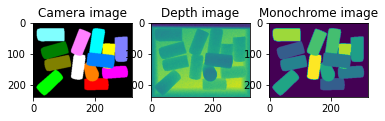

In [3]:
import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
plt.title('Camera image')
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.title('Depth image')
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.title('Monochrome image')
plt.imshow(mono)
plt.show()

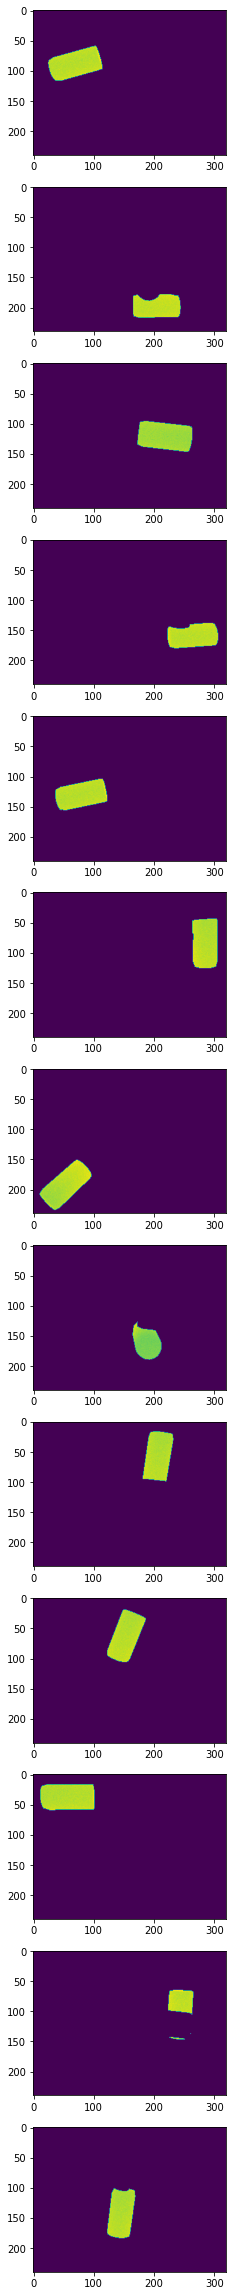

In [4]:
unique_colors=np.unique(mono).tolist()
unique_colors.pop(0) # remove the first color - zero

fig, ax = plt.subplots(len(unique_colors),1,figsize=(24,32))
fig.tight_layout()

for i, color in enumerate(unique_colors):
    cand=np.multiply(depth,mono == color)
    ax[i].imshow(cand)
#    plt.title('Color {}'.format(color))
plt.show()

# Compute Object Pose from Open3D Pointcloud

We can pick individual objects by multiplying the depth image with a mask. We can hence compute the oriented bounding box and the relative pose of the object for the robot to grasp. 

The oriented bounding box data structure provides the center (.center) and orientation (.R), which allows you to compute its pose in the robot's base frame. You can then compute an IK solution that moves the robot arm there. 

In [5]:
cand=np.multiply(depth,mono == 254) # pick the white can

In [6]:
import open3d as o3d

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(image), 
        o3d.geometry.Image(np.array(cand).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1000.0, depth_trunc=1.5)


can = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
       o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
    project_valid_depth_only=True
)

can.paint_uniform_color([1.0, 0, 0]) # you need to color this as the segmentation color is unreliable, in particular for the white object

#o3d.visualization.draw_geometries([can])

obb = can.get_oriented_bounding_box()
obb.color = (0, 1, 0)
o3d.visualization.draw_geometries([obb,can])


2022-03-08 15:22:05.044 Python[51012:1603000] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to (null)


In [7]:
# building the transformation matrix from rotation, translation, and [0 0 0 1]

Randt=np.concatenate((obb.R, np.expand_dims(obb.center, axis=1)),axis=1) # pitfall: arrays need to be passed as a tuple
lastrow=np.expand_dims(np.array([0,0,0,1]),axis=0)
T=np.concatenate((Randt,lastrow))
print(T)

[[ 0.12822872 -0.99139698  0.02625689 -0.03034607]
 [-0.98812642 -0.1299756  -0.08193003  0.05711311]
 [-0.08463794  0.01543935  0.99629215  0.6087047 ]
 [ 0.          0.          0.          1.        ]]


In [16]:
InitialPose.round(3)

array([[-0.011,  0.98 ,  0.199,  0.355],
       [ 0.998, -0.   ,  0.059, -0.127],
       [ 0.058,  0.199, -0.978,  0.733],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])